# Exploratory Data Analysis – Daily Features (v1)

**Purpose**  
Validate the output of the feature engineering pipeline
(`data/curated/features_daily.parquet`) before modeling or backtesting.

This notebook:
- Loads precomputed features
- Performs sanity checks
- Inspects distributions and alignment
- Does NOT modify the pipeline or recompute features

**Input**
- `data/curated/features_daily.parquet`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_parquet("../data/curated/features_daily.parquet")

print(df.shape)
df.head()

(8229, 11)


,date,adj close,close,high,low,open,volume,symbol,ret_1d,rvol_10,y_ret_1d
0,2015-01-16,23.497101,26.497499,26.895000,26.299999,26.757500,314053200,AAPL,-0.007800,0.329180,0.025431
1,2015-01-20,24.102325,27.180000,27.242500,26.625000,26.959999,199599600,AAPL,0.025431,0.323760,0.007605
2,2015-01-21,24.286325,27.387501,27.764999,27.067499,27.237499,194303600,AAPL,0.007605,0.324523,0.025683
3,2015-01-22,24.918148,28.100000,28.117500,27.430000,27.565001,215185600,AAPL,0.025683,0.340529,0.005147
4,2015-01-23,25.046728,28.245001,28.437500,27.882500,28.075001,185859200,AAPL,0.005147,0.285719,0.001062


In [ ]:
# Guarantees no pipeline breakage 

EXPECTED_COLUMNS = {
    "date",
    "symbol",
    "ret_1d",
    "rvol_10",
    "y_ret_1d",
}

missing = EXPECTED_COLUMNS - set(df.columns)
assert not missing, f"Missing expected columns: {missing}"

In [3]:
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

df.groupby("symbol")["date"].apply(
    lambda s: s.is_monotonic_increasing
)

symbol
AAPL    True
MSFT    True
SPY     True
Name: date, dtype: bool

In [ ]:
# We expect zero NaNs, because build_features.py drops them
df[["ret_1d", "rvol_10", "y_ret_1d"]].isna().sum()


ret_1d      0
rvol_10     0
y_ret_1d    0
dtype: int64

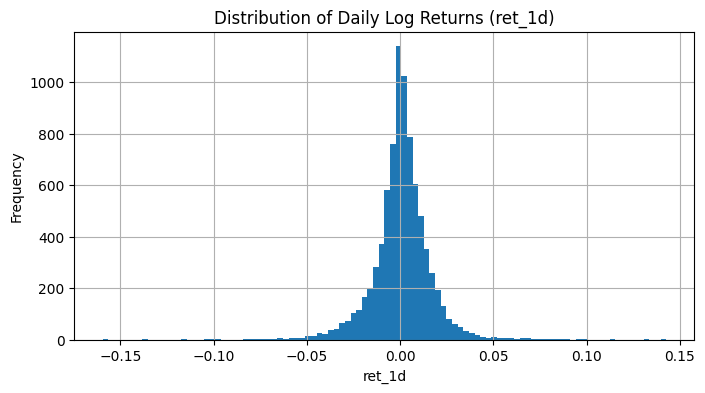

In [ ]:
# We want to see the distribution of ret_1d centered around 0, with heavy tails and no absurd spikes
plt.figure(figsize=(8, 4))
df["ret_1d"].hist(bins=100)
plt.title("Distribution of Daily Log Returns (ret_1d)")
plt.xlabel("ret_1d")
plt.ylabel("Frequency")
plt.show()


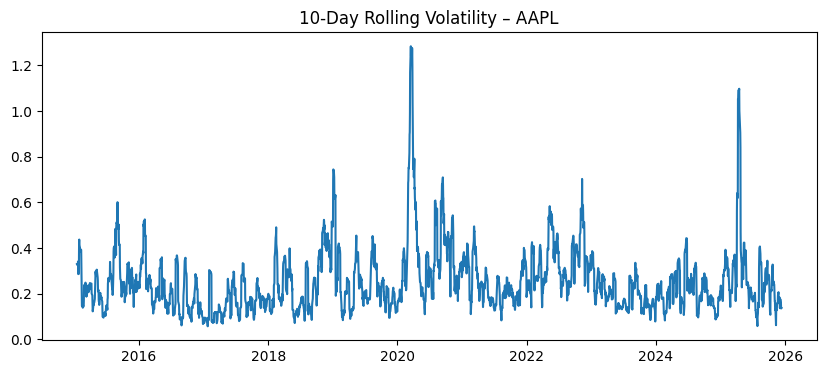

In [ ]:
# Should see volatility clustering, spikes during stress periods, and no flat segments
symbol = "AAPL"
sub = df[df["symbol"] == symbol]

plt.figure(figsize=(10, 4))
plt.plot(sub["date"], sub["rvol_10"])
plt.title(f"10-Day Rolling Volatility – {symbol}")
plt.show()


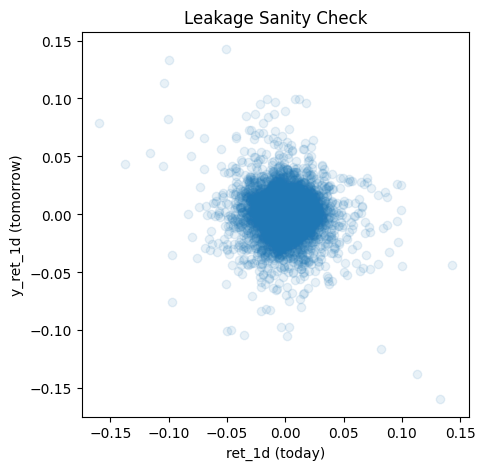

In [ ]:
# Expect to see a noisy cloud, with no diagonal line or structure
plt.figure(figsize=(5, 5))
plt.scatter(
    df["ret_1d"],
    df["y_ret_1d"],
    alpha=0.1
)
plt.xlabel("ret_1d (today)")
plt.ylabel("y_ret_1d (tomorrow)")
plt.title("Leakage Sanity Check")
plt.show()


In [ ]:
# Builds intiution about relative volatility, scale differences, and whether feature behave consistently across assets
df.groupby("symbol")[["ret_1d", "rvol_10"]].agg(
    ["mean", "std", "min", "max"]
)


ret_1d                                 rvol_10                      \
            mean       std       min       max      mean       std       min   
symbol                                                                         
AAPL    0.000854  0.018187 -0.137708  0.142617  0.254043  0.141759  0.056957   
MSFT    0.000862  0.016975 -0.159453  0.132929  0.237103  0.136842  0.037387   
SPY     0.000453  0.011294 -0.115887  0.099863  0.145957  0.107418  0.020060   

                  
             max  
symbol            
AAPL    1.283272  
MSFT    1.421525  
SPY     1.135010

## Conclusions (v1)

- Feature dataset loads successfully from `features_daily.parquet`
- Schema and ordering are correct
- No missing values detected
- Return and volatility distributions look reasonable
- No obvious data leakage detected

### Next steps
- Train a baseline predictive model
- Define a simple trading rule
- Build a toy backtesting engine
